In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import matplotlib as mpl
# enables correct plotting of text
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42 

import scanpy.external as sce

In [2]:
# import session_info
# session_info.show()

In [3]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/home/kk837/rfs/rfs-teichlab-nfs-iCNyzSAaucw/kk837/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

In [4]:
sc.settings.set_figure_params(dpi=80)

# Variables

In [5]:
adata_dir = '/home/kk837/rds/rds-teichlab-C9woKbOCf2Y/kk837/Foetal/anndata_objects/Xenium/subsets'
sample_id = 'C194-HEA-0-FFPE-1_Hst45-HEA-0-FFPE-1_concat'
# celltype = 'Neurons'

In [ ]:
# figdir = '/nfs/team205/heart/fetal_ms_figures/raw_plots_kk/Aug2024'
# table_dir = '/nfs/team205/heart/fetal_ms_figures/tables/Aug2024'

In [6]:
latent_space = 'pca_harmony'

# Read in data

In [7]:
# read in
ad1 = sc.read_h5ad(f'{adata_dir}/{sample_id}_5K_Neurons_lognorm.h5ad')
ad2 = sc.read_h5ad(f'{adata_dir}/{sample_id}_5K_Glia_lognorm.h5ad')

adata = ad1.concatenate(ad2, 
            join='inner', 
            batch_key=None, 
            index_unique=None)
adata

/tmp/ipykernel_349665/1641403099.py:5: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = ad1.concatenate(ad2,


AnnData object with n_obs × n_vars = 8968 × 4226
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'n_genes', 'tissue_block_id', 'celltypist_coarse', 'conf_score_coarse', 'celltypist_coarse_fin', 'celltypist_coarse2midmod', 'conf_score_coarse2midmod', 'celltypist_mid_fin', 'celltypist_midmod2fine', 'conf_score_midmod2fine', 'pca_harmony_leiden_0.2', 'pca_harmony_leiden_0.3', 'pca_harmony_leiden_0.4', 'pca_harmony_leiden_0.5', 'pca_harmony_leiden_0.8', 'pca_harmony_leiden_1.0', 'pca_harmony_leiden_1.5', 'pca_harmony_leiden_2.0', 'pca_harmony_leiden_3.

In [8]:
adata.X.data[:5]

array([3.4320538, 3.4320538, 3.4320538, 3.4320538, 3.4320538],
      dtype=float32)

In [10]:
## Remove mid-grain markers from the feature
# read in markers
midgrain_markers = pd.read_csv('/home/kk837/rfs/rfs-teichlab-nfs-iCNyzSAaucw/kk837/notebooks/Foetal/VisiumHD/re-seq_mpp0p3/sc_midgrain_markers.csv',
                               index_col=0)
# remove the markers of celltype of interest
midgrain_markers = midgrain_markers[midgrain_markers['group'].isin(['Neurons','Glia'])==False]
# remove
mask = [x not in list(midgrain_markers['names']) for x in adata.var_names]
bdata = adata[:,mask]
bdata

View of AnnData object with n_obs × n_vars = 8968 × 3793
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'n_genes', 'tissue_block_id', 'celltypist_coarse', 'conf_score_coarse', 'celltypist_coarse_fin', 'celltypist_coarse2midmod', 'conf_score_coarse2midmod', 'celltypist_mid_fin', 'celltypist_midmod2fine', 'conf_score_midmod2fine', 'pca_harmony_leiden_0.2', 'pca_harmony_leiden_0.3', 'pca_harmony_leiden_0.4', 'pca_harmony_leiden_0.5', 'pca_harmony_leiden_0.8', 'pca_harmony_leiden_1.0', 'pca_harmony_leiden_1.5', 'pca_harmony_leiden_2.0', 'pca_harmony_l

In [11]:
# remove cell cycle genes
cell_cycle_genes = ['MCM5','PCNA','TYMS','FEN1','MCM2','MCM4','RRM1','UNG','GINS2','MCM6','CDCA7','DTL','PRIM1','UHRF1','MLF1IP','HELLS','RFC2','RPA2','NASP',
                'RAD51AP1','GMNN','WDR76','SLBP','CCNE2','UBR7','POLD3','MSH2','ATAD2','RAD51','RRM2','CDC45','CDC6','EXO1','TIPIN','DSCC1','BLM','CASP8AP2',
                'USP1','CLSPN','POLA1','CHAF1B','BRIP1','E2F8','HMGB2','CDK1','NUSAP1','UBE2C','BIRC5','TPX2','TOP2A','NDC80','CKS2','NUF2','CKS1B','MKI67',
                'TMPO','CENPF','TACC3','FAM64A','SMC4','CCNB2','CKAP2L','CKAP2','AURKB','BUB1','KIF11','ANP32E','TUBB4B','GTSE1','KIF20B','HJURP','CDCA3','HN1',
                'CDC20','TTK','CDC25C','KIF2C','RANGAP1','NCAPD2','DLGAP5','CDCA2','CDCA8','ECT2','KIF23','HMMR','AURKA','PSRC1','ANLN','LBR','CKAP5','CENPE','CTCF',
                'NEK2','G2E3','GAS2L3','CBX5','CENPA']
mask = [x not in cell_cycle_genes for x in bdata.var_names]
bdata = bdata[:,mask]
bdata.shape

(8968, 3740)

In [12]:
# HVGs, using the object which doesn't have midgrain markers
sc.pp.highly_variable_genes(bdata, flavor='seurat', min_mean=0.0125, max_mean=3, min_disp=0.5)
print(f'number of hvgs: {sum(bdata.var.highly_variable)}')
# PCA using the degected HVGs
sc.tl.pca(bdata, use_highly_variable=True)
adata.obsm['X_pca'] = bdata.obsm['X_pca'].copy()
# harmony integration
sce.pp.harmony_integrate(adata, 'tissue_block_id', basis='X_pca', adjusted_basis='X_pca_harmony')
# create neighbour graph
latent_space = 'pca_harmony'
sc.pp.neighbors(adata,n_neighbors=15,use_rep=f"X_{latent_space}",key_added=latent_space)
# visualisation with umap
sc.tl.umap(adata,min_dist=0.1,neighbors_key=latent_space)
adata.obsm[f"X_umap_{latent_space}"]=adata.obsm["X_umap"]
del adata.obsm["X_umap"]

/home/kk837/.conda/envs/generic_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:698: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
/home/kk837/.conda/envs/generic_env/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:438: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


number of hvgs: 827


2025-06-12 17:52:22,562 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-12 17:52:25,016 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-12 17:52:25,108 - harmonypy - INFO - Iteration 1 of 10
2025-06-12 17:52:26,304 - harmonypy - INFO - Iteration 2 of 10
2025-06-12 17:52:27,502 - harmonypy - INFO - Converged after 2 iterations
/home/kk837/.conda/envs/generic_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


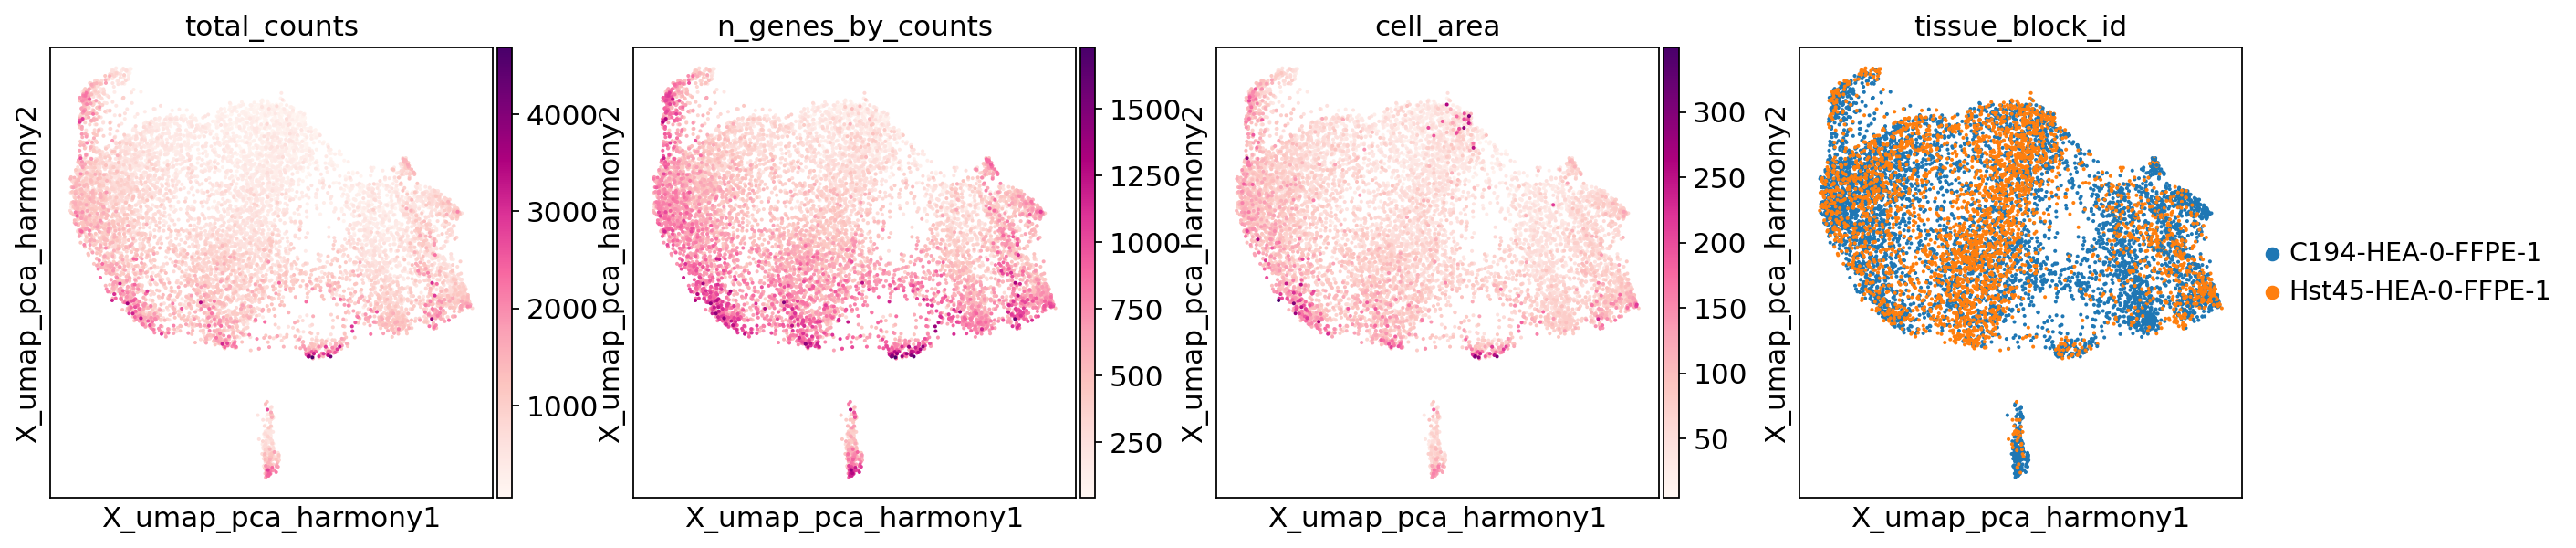

In [13]:
sc.pl.embedding(adata, basis=f"X_umap_{latent_space}",
                color=['total_counts','n_genes_by_counts','cell_area','tissue_block_id'],
                    wspace=0.2,cmap='RdPu',vmax='p100')

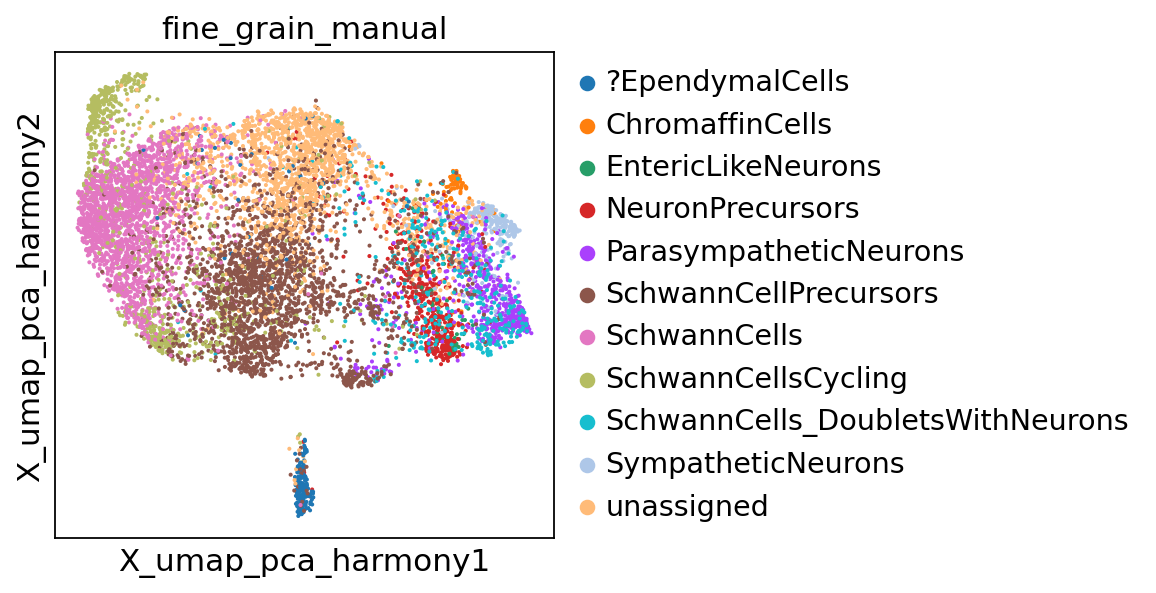

In [14]:
sc.pl.embedding(adata, basis=f"X_umap_{latent_space}",
                color=['fine_grain_manual'],
                    wspace=0.2,cmap='RdPu',vmax='p100')

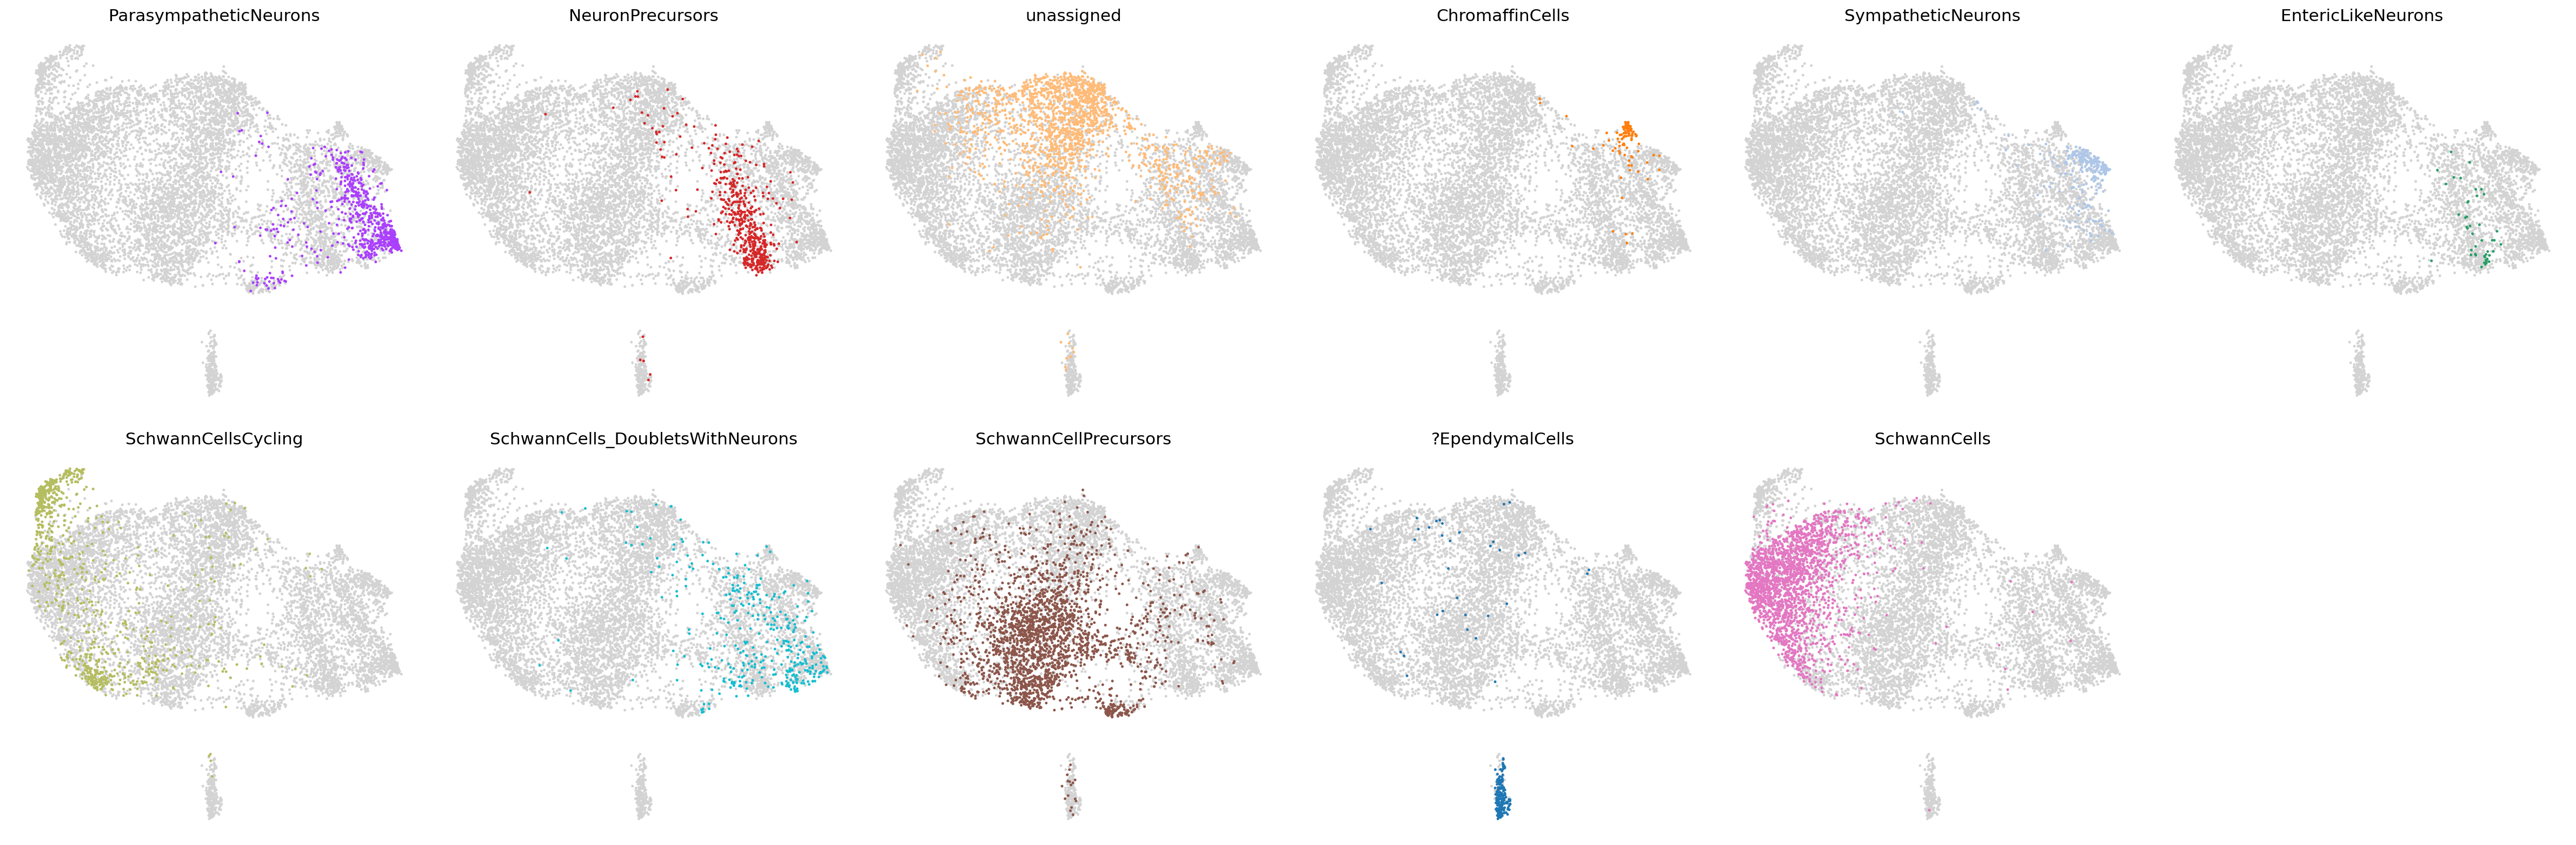

In [15]:
group_col = 'fine_grain_manual'
groups_to_plot = adata.obs[group_col].unique()
basis = f"X_umap_{latent_space}"

ncols = 6
if len(groups_to_plot)%ncols==0:
    nrows = len(groups_to_plot)//ncols
else:
    nrows = len(groups_to_plot)//ncols+1

if len(groups_to_plot)<ncols:
    fig_width = len(groups_to_plot)%ncols
else:
    fig_width = ncols
    
fig,axs=plt.subplots(nrows=nrows,ncols=ncols,figsize=(fig_width*5,nrows*5))
# Flatten the axs array for easier iteration in case of multiple rows and columns
axs_flat = axs.flatten()

for i,grp in enumerate(groups_to_plot):
    # ad = adata.copy()
    # update colors
    # get color in adata
    # ind = list(ad.obs[group_col].cat.categories).index(celltype)
    # ad.uns[group_col][ind] = 'darkred'
    
    # title
    middle_ind = round(len(grp)/2)
    # grp_title = f'{grp[:middle_ind]}\n{grp[middle_ind:]}'
    # plot
    sc.pl.embedding(adata, basis=basis,
                  color=group_col, groups=grp,
                  size=20,legend_loc=None,
                  frameon=False,title=grp,
                  show=False, ax=axs_flat[i],
                 )
# Turn off any remaining subplots
for j in range(len(groups_to_plot), len(axs_flat)):
    fig.delaxes(axs_flat[j])

# fig.suptitle('Main Title for the Figure')
fig.tight_layout()

categories: ?EpendymalCells, ChromaffinCells, EntericLikeNeurons, etc.
var_group_labels: Neuronal, ChromaffinCells, NeuronPrecursors, etc.


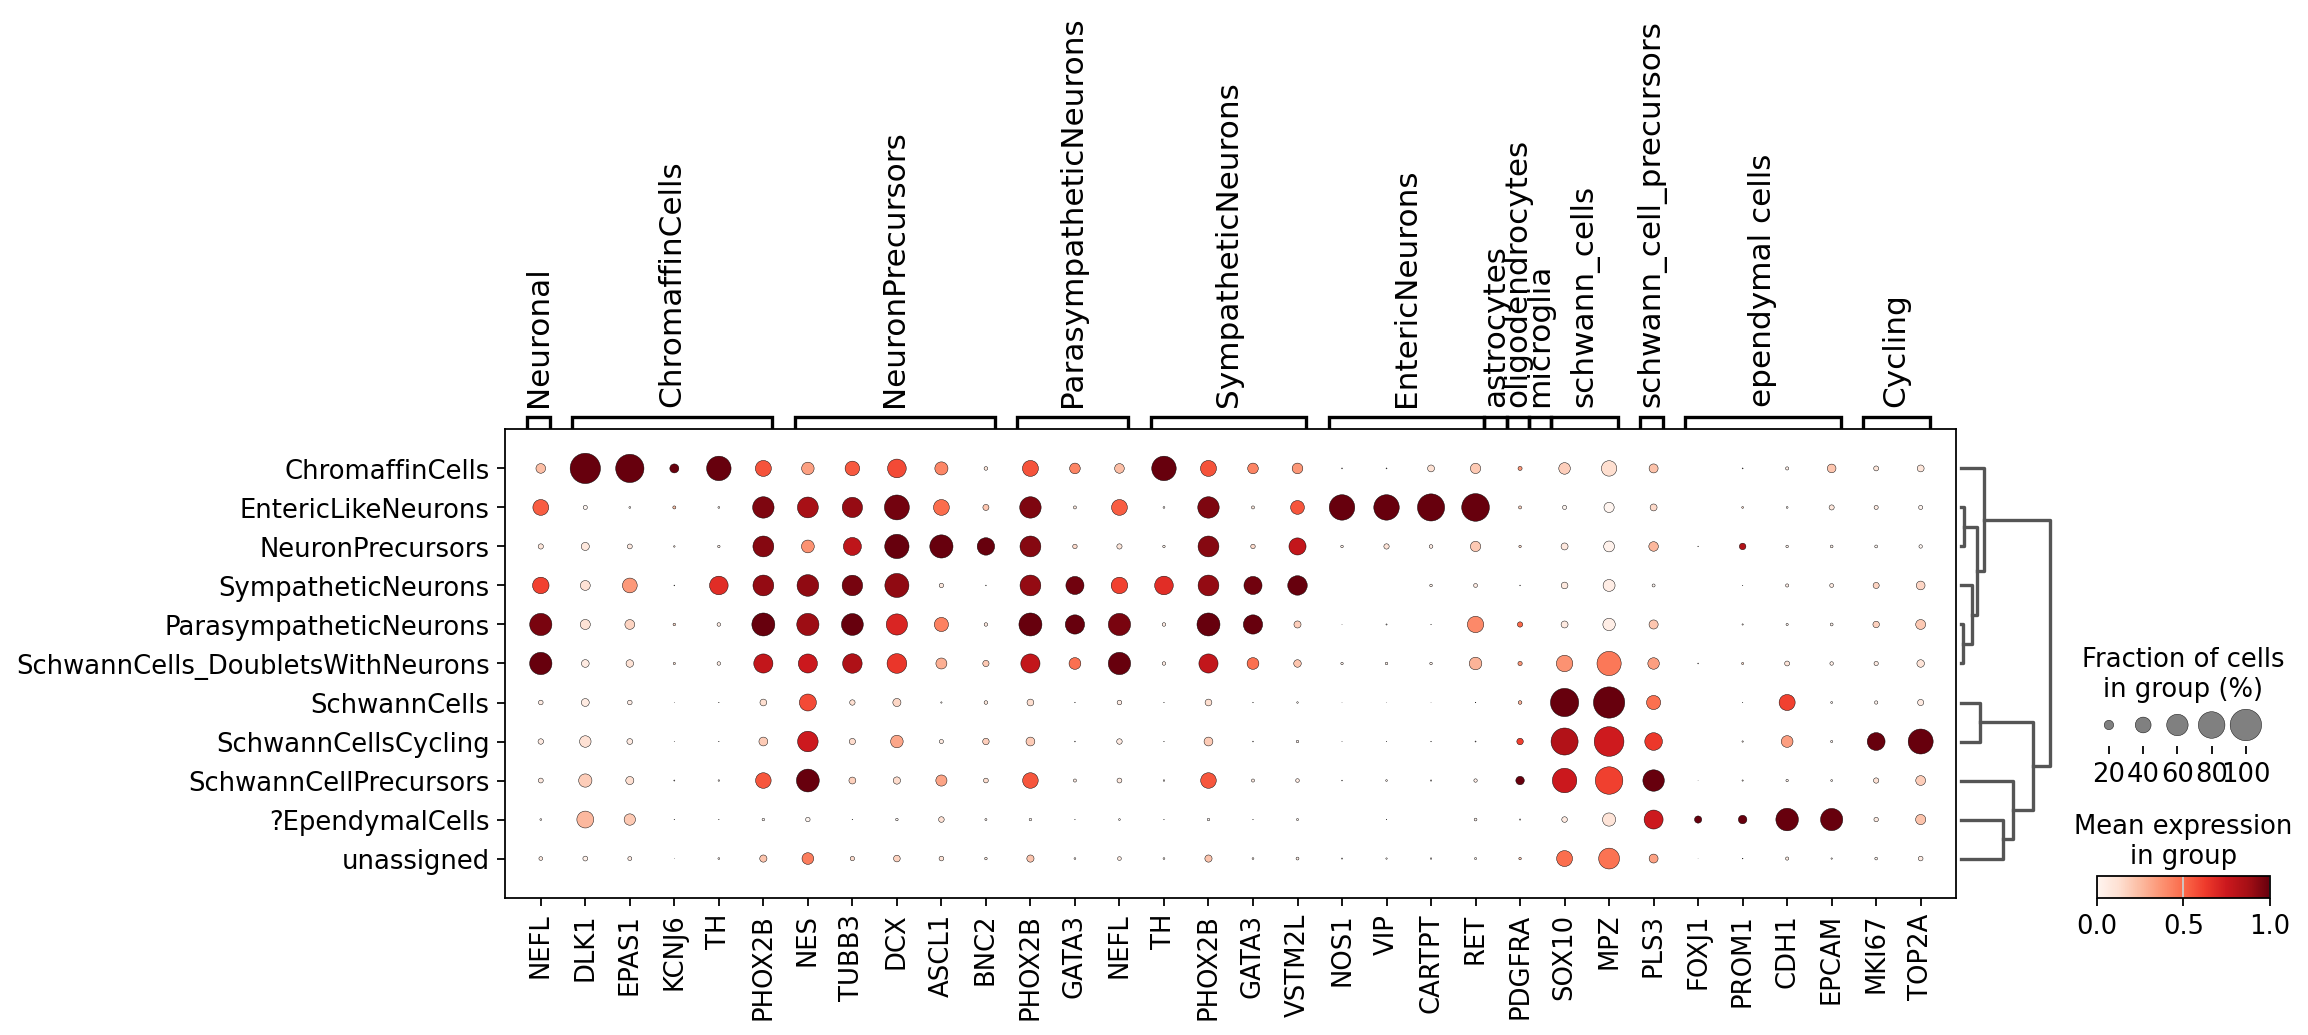

In [16]:
# markers for fine-grained cell types
markers = {
    'Neuronal':['NEFL','RBFOX3'],
    "ChromaffinCells": [
        'DLK1',
        'EPAS1',
        'KCNJ6',
        "TH",    # Tyrosine hydroxylase
        "PNMT",  # Phenylethanolamine N-methyltransferase
        "CHGA",  # Chromogranin A
        "CHGB",  # Chromogranin B
        "PHOX2B"
    ],
    "NeuronPrecursors": [
        "NES",    # Nestin
        "PAX6",   # Paired box 6
        "TUBB3",  # Tubulin Beta 3 Class III
        "DCX",     # Doublecortin
        'ASCL1','NELL2','BNC2'
    ],
    "ParasympatheticNeurons": [
        "PHOX2B",
        "CHAT",    # Choline O-Acetyltransferase
        "SLC18A3", # Solute Carrier Family 18 Member A3 (Vesicular Acetylcholine Transporter)
        "GATA3",
        'NEFL','SST'
    ],
    "SympatheticNeurons": [
        "TH",
        "PHOX2B",
        "GATA3",
        "CHGA",
        "CHGB",
        'DBH','VSTM2L'
    ],
    'EntericNeurons':['NOS1', 'VIP', 'CARTPT', 'RET'],
    
     "astrocytes": ["GFAP", "S100B", "ALDH1L1"],
    "oligodendrocytes": ["OLIG2", "MBP", "PDGFRA"],
    "microglia": ["AIF1"],  # IBA1 protein is encoded by the AIF1 gene
    "schwann_cells": ["SOX10", "MPZ", "S100B"],
    "schwann_cell_precursors": [
                                "PLS3",'SLITRK6','IL1RAPL2'
                               ],
    "ependymal cells":[
                    "FOXJ1",  # Forkhead box J1
                    "S100B",  # S100 Calcium Binding Protein B
                    "VIM",    # Vimentin
                    "PROM1",  # Prominin-1 (CD133)
                    "CDH1",   # Cadherin 1 (E-cadherin)
                    "EPCAM"   # Epithelial Cell Adhesion Molecule
    ],
    
    'Cycling':['MKI67','TOP2A']
}
genes = []
for g in markers.values():
    genes = genes + [x for x in g if (x in adata.var_names)&(x not in genes)]
for key in markers.keys():
    markers[key]=[x for x in markers[key] if x in adata.var_names]

sc.tl.dendrogram(adata,groupby='fine_grain_manual')
sc.pl.dotplot(adata,
              var_names=markers,
              groupby='fine_grain_manual',
              standard_scale='var',
              dendrogram=True
             )